# Random Forest Regression — End-to-End

This notebook implements an end-to-end Random Forest regression pipeline for forecasting `Units Sold`.

**Contents:**
1. Imports & helper functions
2. Load dataset
3. Preprocessing & feature engineering
4. Train/Test split
5. Baseline Random Forest
6. Light hyperparameter tuning (GridSearchCV)
7. Evaluation & comparison
8. Feature importances & diagnostic plots
9. Save model

Place `retail_store_inventory.csv` in the same directory as this notebook before running.

In [ ]:
# 1) Imports & helper functions
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

def smape(actual, forecast):
    actual = np.array(actual, dtype=float)
    forecast = np.array(forecast, dtype=float)
    denom = (np.abs(actual) + np.abs(forecast))
    mask = denom == 0
    denom[mask] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(forecast - actual) / denom)

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"sMAPE: {smape_val:.4f}%")
    print(f"R²:   {r2:.4f}")
    return {'MAE': mae, 'RMSE': rmse, 'sMAPE': smape_val, 'R2': r2}

Mounted at /content/drive


In [ ]:
# 2) Load dataset
file_path = '/content/drive/MyDrive/data/retail_store_inventory.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path} - put 'retail_store_inventory.csv' in the same folder as this notebook.")

df = pd.read_csv(file_path)
print('Loaded dataset shape:', df.shape)
display(df.head())

Loaded dataset shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
# 3) Preprocessing & feature engineering
# Basic missing value handling
df = df.fillna(method='ffill').fillna(method='bfill')

# Date features (if present)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Date'].notnull()].copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Ensure target exists
target_col = 'Units Sold'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {df.columns.tolist()}")

# Drop identifiers (if present)
drop_cols = [c for c in ['Store ID','Product ID','Date'] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)

# One-hot encode categorical features
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print('Categorical columns:', cat_cols)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print('\nFinal shape after preprocessing:', df.shape)

/tmp/ipython-input-3226282369.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Categorical columns: ['Category', 'Region', 'Weather Condition', 'Seasonality']

Final shape after preprocessing: (73100, 27)


In [ ]:
# 4) Train/Test split
X = df.drop(columns=[target_col])
y = df[target_col]

# Drop rows with non-finite numeric values
mask_valid = np.isfinite(X.select_dtypes(include=[np.number])).all(axis=1)
if not mask_valid.all():
    X = X[mask_valid].copy()
    y = y[mask_valid].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (58480, 26) Test shape: (14620, 26)


In [ ]:
# 5) Baseline Random Forest (no tuning)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols)], remainder='passthrough')

rf_pipe = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
print('\nBaseline Random Forest performance:')
metrics_rf = print_metrics(y_test, y_pred_rf)


Baseline Random Forest performance:
MAE:  7.2595
RMSE: 8.5520
sMAPE: 14.5224%
R²:   0.9938


In [ ]:
# 6) Light hyperparameter tuning with GridSearchCV (smaller grid to keep runtime reasonable)
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print('\nBest Random Forest params:', grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best Random Forest params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 200}


In [ ]:
# 7) Evaluate tuned Random Forest on test set
y_pred_best_rf = best_rf.predict(X_test)
print('\nTuned Random Forest performance on test set:')
metrics_rf_tuned = print_metrics(y_test, y_pred_best_rf)

# Compare baseline vs tuned
import pandas as pd
compare = pd.DataFrame([metrics_rf, metrics_rf_tuned], index=['Baseline RF', 'Tuned RF']).T
display(compare)

# Save comparison
compare.to_csv('random_forest_comparison.csv')
print('\nSaved comparison to random_forest_comparison.csv')


Tuned Random Forest performance on test set:
MAE:  7.1572
RMSE: 8.3889
sMAPE: 14.3184%
R²:   0.9941


,Baseline RF,Tuned RF
MAE,7.259495,7.157194
RMSE,8.551981,8.388879
sMAPE,14.522403,14.318422
R2,0.993823,0.994056



Saved comparison to random_forest_comparison.csv



Top 20 feature importances:


,0
Demand Forecast,0.999188
Inventory Level,0.000307
Units Ordered,0.000081
Price,0.000073
Competitor Pricing,0.000070
Day,0.000062
WeekOfYear,0.000057
DayOfWeek,0.000024
Discount,0.000020
Month,0.000016


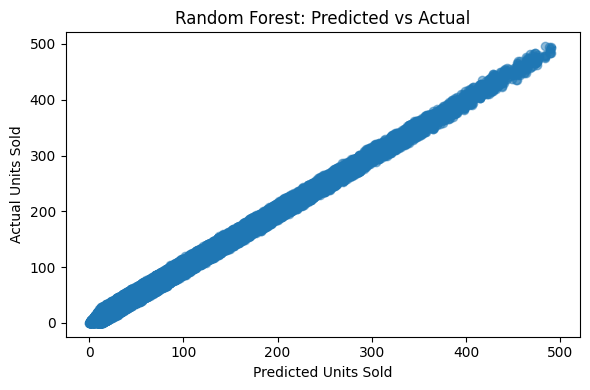

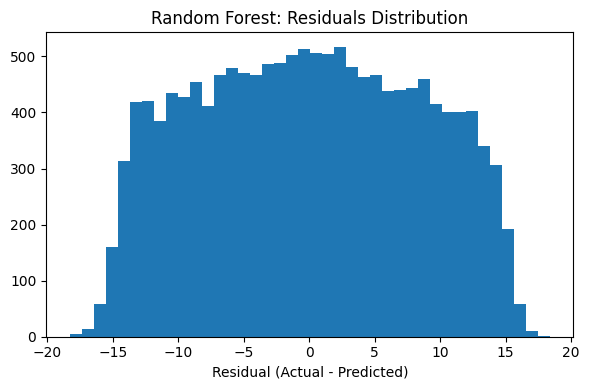

In [ ]:
# 8) Feature importances and diagnostics
# Reconstruct feature names as numeric_cols then remainder passthrough columns
remainder_cols = [c for c in X_train.columns if c not in numeric_cols]
feature_names = numeric_cols + remainder_cols

rf_step = best_rf.named_steps['rf']
feat_imp = pd.Series(rf_step.feature_importances_, index=feature_names).sort_values(ascending=False)
print('\nTop 20 feature importances:')
display(feat_imp.head(20))

# Diagnostic plots
residuals = y_test - y_pred_best_rf
plt.figure(figsize=(6,4))
plt.scatter(y_pred_best_rf, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', linewidth=1)
plt.xlabel('Predicted Units Sold')
plt.ylabel('Actual Units Sold')
plt.title('Random Forest: Predicted vs Actual')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Random Forest: Residuals Distribution')
plt.tight_layout()
plt.show()

In [ ]:
# 9) Save best pipeline
joblib.dump(best_rf, 'best_random_forest_pipeline.joblib')
print('Saved: best_random_forest_pipeline.joblib')

Saved: best_random_forest_pipeline.joblib
